# CNN - LSTM Model for Time Series Forecasting

This workbook will use load the cleaned pond 2 dataframe for training and predicting each attribute (Sensor Data) for the next 24 hours. The dataset will be reduced to 40% of the size for training and testing. The truncated dataframe will then be split into 80% training and 20% testing. The training data will be reshaped to be 3D for the CNN-LSTM model. The model will be trained and tested. The model will then be used to predict the next 24 hours of data for each attribute. The predicted data will be saved to a csv file for use in the dashboard.

In [124]:
# Import libraries
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [125]:
# Load the data
df = pd.read_csv('../Data/cleaned_Pond2.csv', delimiter=',', low_memory=False )

In [126]:
# Drop the columns that are not needed
df.drop("Unnamed: 0",axis=1,inplace=True)
df.drop("Population",axis=1,inplace=True)
df.drop("Date",axis=1,inplace=True)
df.drop("Time",axis=1,inplace=True)
df.drop("Weight_diff",axis=1,inplace=True)
df.drop("Fish_Length",axis=1,inplace=True)
df.drop("Fish_Weight",axis=1,inplace=True)
df.head(5)

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate,Datetime
0,24.8750,100,4.505,8.43365,0.38,193,2021-06-19 00:00:05
1,24.9375,100,6.601,8.43818,0.38,194,2021-06-19 00:01:02
2,24.8750,100,15.797,8.42457,0.38,192,2021-06-19 00:01:22
3,24.9375,100,5.046,8.43365,0.38,193,2021-06-19 00:01:44
4,24.9375,100,38.407,8.40641,0.38,192,2021-06-19 00:02:07


In [127]:
# Set the index to the Datetime column
df['Datetime'] = pd.to_datetime(df.Datetime,infer_datetime_format=True)
df.set_index("Datetime",inplace=True)
df=df.resample('min').ffill()
df=df.bfill()

In [128]:
# Reset the index
df.reset_index(inplace=True)

In [129]:
df.head()

,Datetime,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
0,2021-06-19 00:00:00,24.8750,100.0,4.505,8.43365,0.38,193.0
1,2021-06-19 00:01:00,24.8750,100.0,4.505,8.43365,0.38,193.0
2,2021-06-19 00:02:00,24.9375,100.0,5.046,8.43365,0.38,193.0
3,2021-06-19 00:03:00,24.8750,100.0,2.831,8.43818,0.38,194.0
4,2021-06-19 00:04:00,24.8750,100.0,17.005,8.43365,0.38,192.0


In [130]:
df.describe()

,Temperature,Turbidity,Dissolved Oxygen,PH,Ammonia,Nitrate
count,192960.00000,192960.000000,192960.000000,192960.000000,1.929600e+05,192960.000000
mean,24.90110,95.079519,6.784840,5.186690,1.644444e+08,749.050643
std,0.82809,16.312601,9.219671,3.238303,8.591875e+09,408.174637
min,23.00000,1.000000,0.007000,-3.137450,6.770000e-03,61.000000
25%,24.25000,100.000000,2.163000,2.446090,8.196800e-01,204.000000
50%,24.81250,100.000000,3.200000,7.003710,5.979360e+00,938.000000
75%,25.43750,100.000000,6.795000,7.421340,2.608377e+01,1072.000000
max,27.81250,100.000000,41.011000,8.551670,9.965130e+11,2077.000000


In [131]:
#  Percent Function for data split
def percentage(percent, whole):
  return (percent * whole) / 100.0

In [132]:
#  Set the percentage of data to work with and Display the number of rows to work with
chunk_prctg=40
training_prctg=80
validation_prctg=20

rows_to_work_with=round(percentage(chunk_prctg, df.shape[0]))
print('rows_to_work_with ',rows_to_work_with)
training_rows_to_work_with=round(percentage(training_prctg, rows_to_work_with))
print('training_rows_to_work_with',training_rows_to_work_with)

rows_to_work_with  77184
training_rows_to_work_with 61747


In [133]:
# It does not make sense to randomize our data . In machine learning, train/test split splits the data randomly, 
# as there’s no dependence from one observation to the other. That’s not the case with our time series data.
# Here, we’ll want to use values at the rear of the dataset for testing and everything else for training.
# create your training and validation sets here
start_index=0
train_df = df[start_index:training_rows_to_work_with]
val_df = df[training_rows_to_work_with:rows_to_work_with]

<AxesSubplot:>

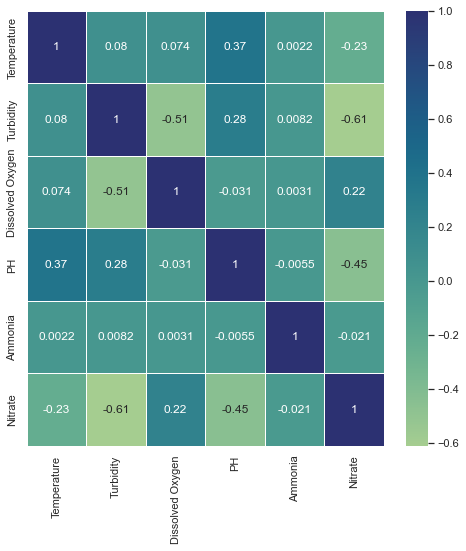

In [134]:
# Correlation Matrix
import seaborn as sns; sns.set()
plt.figure(figsize=(8,8))
sns.heatmap(train_df.corr(), annot=True, cmap='crest',linewidth=.5  )

In [135]:
# Create a csv file of the validation data for global use
val_df.to_csv('../Data/val_df.csv', index=False)

Temperature Predictions: 

In [136]:
# Set the X and y values
X_train = train_df[['Temperature','PH']]
y_train = train_df['Temperature']
X_test = val_df[['Temperature','PH']]

# Import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)
# Transform the training data
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)


Preparing our Training Data sequences with label predictions

In [137]:
# Start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1

# Set the number of rows to work with
num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Temperature'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [138]:
#  Display the shape of the arrays
seq_arrays.shape

(61744, 2, 2)

In [139]:
#  Display the shape of the labels
seq_labs.shape

(61744, 1)

Preparing our Test Data sequences with label predictions

In [140]:
#  Create the validation arrays and labels
val_arrays = []
val_labs = []
#  Set the number of rows to work with
num_test_rows=val_df.shape[0]
# Set the starting index
i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Temperature'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Temperature'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Temperature"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [141]:
# Display the shape of the validation arrays
val_arrays.shape

(15435, 2, 2)

In [142]:
# Display the shape of the validation labels
val_labs.shape

(15435, 1)

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. The model design consists of a stack of Conv1D layers with increasing dilation rates, followed by an LSTM layer, a Dense layer with linear activation, and an Adam optimizer with a learning rate of 0.001. The model is designed to predict temperature values based on a sequence of input features, with the use of BatchNormalization and Dropout layers to improve its generalization ability.


CNN-LSTM Model

In [143]:
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_temperature.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 2, 32)             160       
                                                                 
 batch_normalization_23 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_24 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_24 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 2, 48)            

In [144]:
# Fit the model to the training data
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 13s - loss: 55.4594 - mse: 55.4594 - val_loss: 0.1553 - val_mse: 0.1553 - 13s/epoch - 11ms/step
Epoch 2/100
1174/1174 - 6s - loss: 3.2879 - mse: 3.2879 - val_loss: 0.0301 - val_mse: 0.0301 - 6s/epoch - 5ms/step
Epoch 3/100
1174/1174 - 6s - loss: 3.1368 - mse: 3.1368 - val_loss: 0.0243 - val_mse: 0.0243 - 6s/epoch - 6ms/step
Epoch 4/100
1174/1174 - 6s - loss: 3.0317 - mse: 3.0317 - val_loss: 0.0182 - val_mse: 0.0182 - 6s/epoch - 5ms/step
Epoch 5/100
1174/1174 - 6s - loss: 2.9758 - mse: 2.9758 - val_loss: 0.0084 - val_mse: 0.0084 - 6s/epoch - 5ms/step
Epoch 6/100
1174/1174 - 6s - loss: 2.8717 - mse: 2.8717 - val_loss: 0.0270 - val_mse: 0.0270 - 6s/epoch - 5ms/step
Epoch 7/100
1174/1174 - 6s - loss: 2.8045 - mse: 2.8045 - val_loss: 0.0191 - val_mse: 0.0191 - 6s/epoch - 5ms/step
Epoch 8/100
1174/1174 - 6s - loss: 2.6987 - mse: 2.6987 - val_loss: 0.0329 - val_mse: 0.0329 - 6s/epoch - 5ms/step
Epoch 9/100
1174/1174 - 6s - loss: 2.5987 - mse: 2.5987 - val_loss: 0.0109 

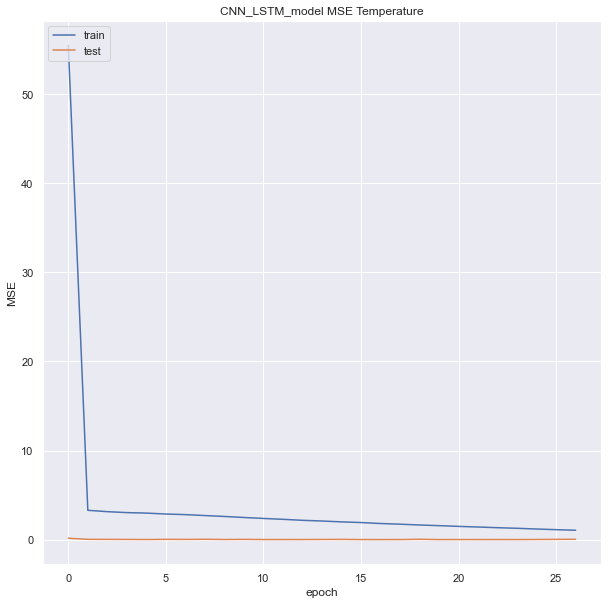

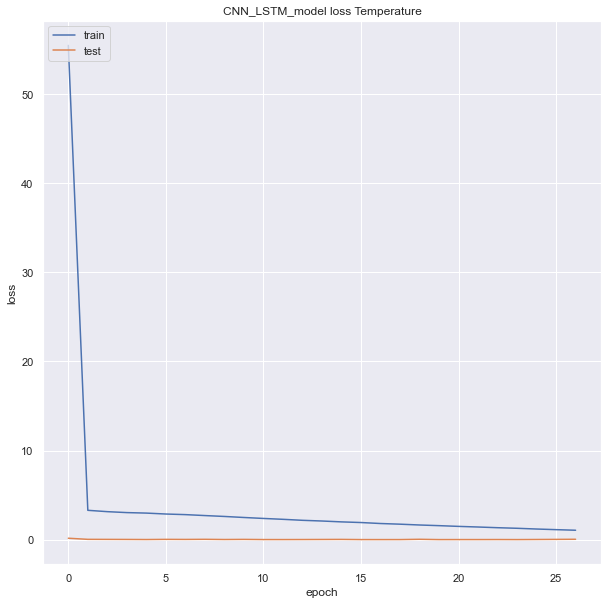

In [145]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Temperature')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_temperature.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Temperature')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_temperature.png")


We will now run this validation data through our CNN-LSTM model and visualize its performance 

483/483 - 1s - loss: 0.0740 - mse: 0.0740 - 827ms/epoch - 2ms/step

MSE: 0.07397671043872833
483/483 [==============================] - 2s 2ms/step


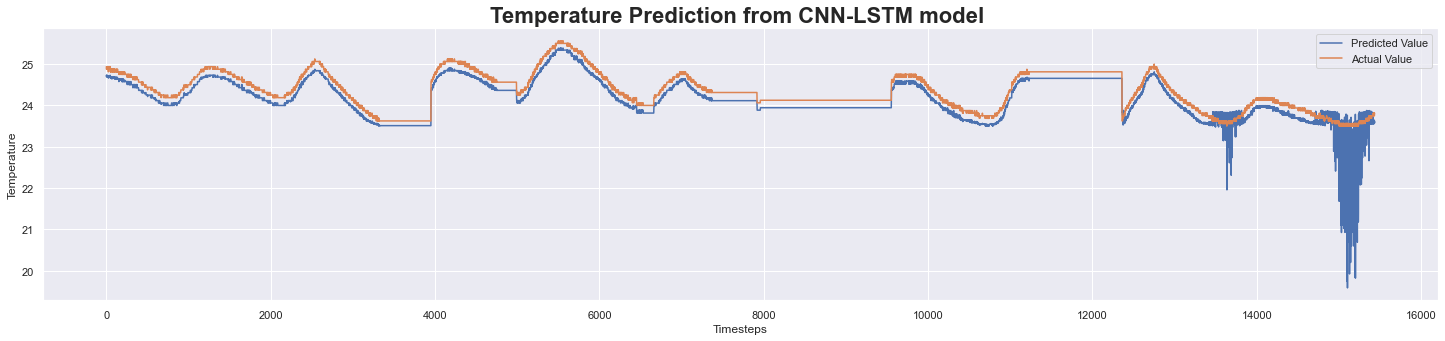

In [146]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/temperature_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Temperature Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Temperature')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/temperature_predictions.png")

## pH Predictions

The section uses a similar model to the previous one, but for predicting pH values instead of temperature. It initializes the Sequential model and adds Conv1D layers with different dilation rates, BatchNormalization and Dropout layers, an LSTM layer, and a Dense layer with linear activation. It uses the Adam optimizer with a learning rate of 0.001.

In [147]:
# Create the training arrays and labels
X_train = train_df[['Temperature','PH']]
y_train = train_df['PH']
X_test = val_df[['Temperature','PH']]
# Import the MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)
# Transform the training data
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [148]:
# Start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1

# Get the number of rows in the training data
num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['PH'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [149]:
# Set the validation arrays and labels
val_arrays = []
val_labs = []
# Get the number of rows in the validation data
num_test_rows=val_df.shape[0]
# Set the starting index
i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['PH'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['PH'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["PH"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [150]:
# Display the shape of the training and validation arrays
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)


(15435, 2, 2) (15435, 1) (61744, 2, 2) (61744, 1)


In [151]:
# Build the model
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_pH.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_26 (Conv1D)          (None, 2, 32)             160       
                                                                 
 batch_normalization_26 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_35 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_27 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_27 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 2, 48)            

In [152]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 10s - loss: 2.2986 - mse: 2.2986 - val_loss: 0.0205 - val_mse: 0.0205 - 10s/epoch - 9ms/step
Epoch 2/100
1174/1174 - 7s - loss: 0.3375 - mse: 0.3375 - val_loss: 0.0126 - val_mse: 0.0126 - 7s/epoch - 6ms/step
Epoch 3/100
1174/1174 - 7s - loss: 0.3058 - mse: 0.3058 - val_loss: 0.0111 - val_mse: 0.0111 - 7s/epoch - 6ms/step
Epoch 4/100
1174/1174 - 6s - loss: 0.2862 - mse: 0.2862 - val_loss: 2.2188e-04 - val_mse: 2.2188e-04 - 6s/epoch - 5ms/step
Epoch 5/100
1174/1174 - 6s - loss: 0.2653 - mse: 0.2653 - val_loss: 6.1953e-04 - val_mse: 6.1953e-04 - 6s/epoch - 5ms/step
Epoch 6/100
1174/1174 - 7s - loss: 0.2390 - mse: 0.2390 - val_loss: 0.0021 - val_mse: 0.0021 - 7s/epoch - 6ms/step
Epoch 7/100
1174/1174 - 6s - loss: 0.2164 - mse: 0.2164 - val_loss: 0.0094 - val_mse: 0.0094 - 6s/epoch - 5ms/step
Epoch 8/100
1174/1174 - 6s - loss: 0.1901 - mse: 0.1901 - val_loss: 0.0046 - val_mse: 0.0046 - 6s/epoch - 5ms/step
Epoch 9/100
1174/1174 - 6s - loss: 0.1646 - mse: 0.1646 - val_

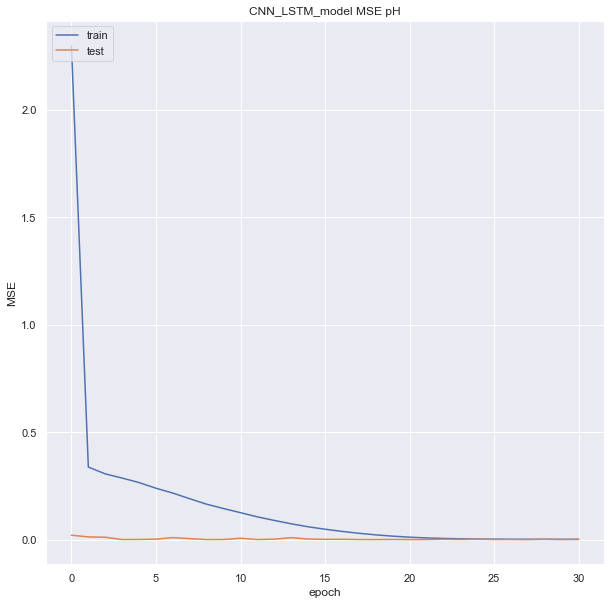

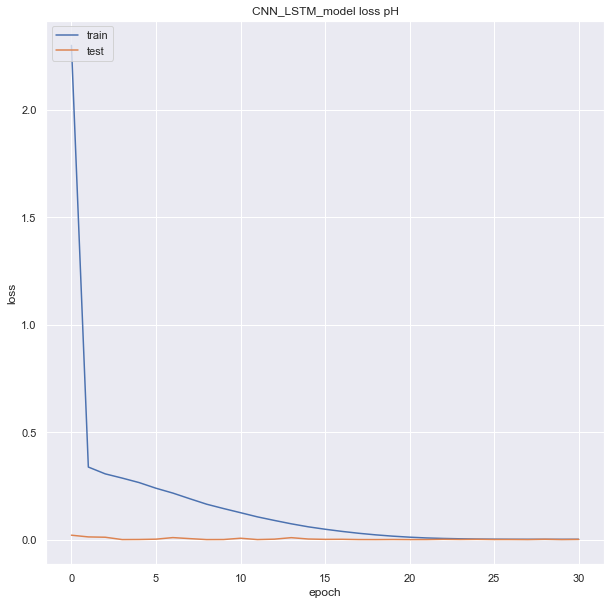

In [153]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE pH')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_pH.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss pH')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_pH.png")


483/483 - 1s - loss: 0.0107 - mse: 0.0107 - 823ms/epoch - 2ms/step

MSE: 0.01071078423410654
483/483 [==============================] - 2s 2ms/step


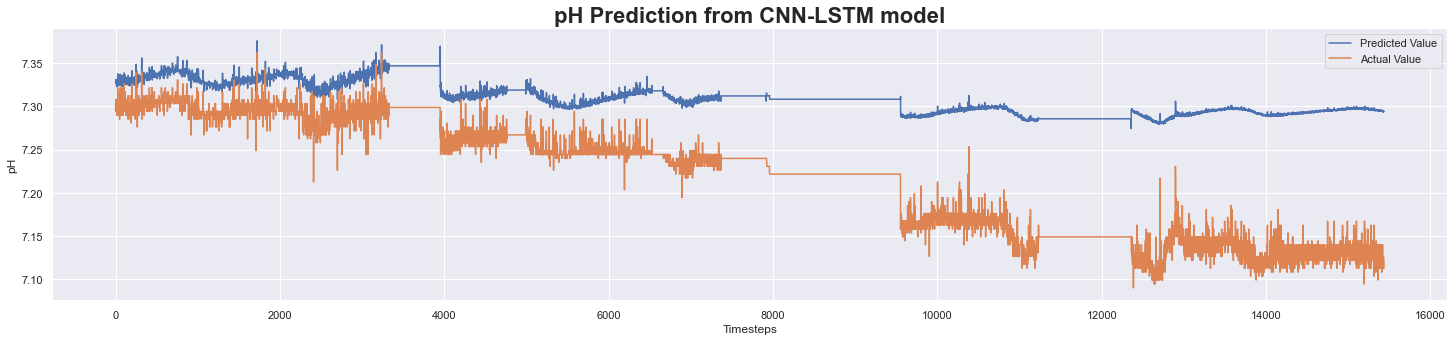

In [154]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/pH_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('pH Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('pH')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/pH_Predictions.png")

## Turbidity Predictions

This section uses a similar architecture as the previous models with Conv1D layers, BatchNormalization and Dropout layers, an LSTM layer, a Dense layer with linear activation, and an Adam optimizer with a higher learning rate of 0.01. 

In [155]:
# Turbidity
X_train = train_df[['Turbidity']]
y_train = train_df['Turbidity']
X_test = val_df[['Turbidity']]
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)
# Transform the training data
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [156]:
# Start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1

# Get the number of rows in the training data
num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Turbidity'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [157]:
# Set the validation arrays and labels
val_arrays = []
val_labs = []
# Get the number of rows in the validation data
num_test_rows=val_df.shape[0]
# Set the starting index for the validation data
i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Turbidity'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Turbidity'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Turbidity"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [158]:
# Print the shape of the arrays
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [159]:
# Build the model
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_turbidity.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 2, 32)             96        
                                                                 
 batch_normalization_29 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_39 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_30 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_30 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 2, 48)           

In [160]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=100,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
587/587 - 9s - loss: 1484.8702 - mse: 1484.8702 - val_loss: 3930.6182 - val_mse: 3930.6182 - 9s/epoch - 15ms/step
Epoch 2/100
587/587 - 4s - loss: 59.4101 - mse: 59.4101 - val_loss: 77.3523 - val_mse: 77.3523 - 4s/epoch - 7ms/step
Epoch 3/100
587/587 - 4s - loss: 50.2295 - mse: 50.2295 - val_loss: 26.9482 - val_mse: 26.9482 - 4s/epoch - 7ms/step
Epoch 4/100
587/587 - 4s - loss: 49.3603 - mse: 49.3603 - val_loss: 145.9499 - val_mse: 145.9499 - 4s/epoch - 6ms/step
Epoch 5/100
587/587 - 5s - loss: 48.2083 - mse: 48.2083 - val_loss: 71.2137 - val_mse: 71.2137 - 5s/epoch - 8ms/step
Epoch 6/100
587/587 - 4s - loss: 47.9958 - mse: 47.9958 - val_loss: 100.3664 - val_mse: 100.3664 - 4s/epoch - 7ms/step
Epoch 7/100
587/587 - 5s - loss: 46.1619 - mse: 46.1619 - val_loss: 56.9115 - val_mse: 56.9115 - 5s/epoch - 8ms/step
Epoch 8/100
587/587 - 4s - loss: 45.5937 - mse: 45.5937 - val_loss: 85.6952 - val_mse: 85.6952 - 4s/epoch - 7ms/step
Epoch 9/100
587/587 - 4s - loss: 45.1623 - mse: 45.

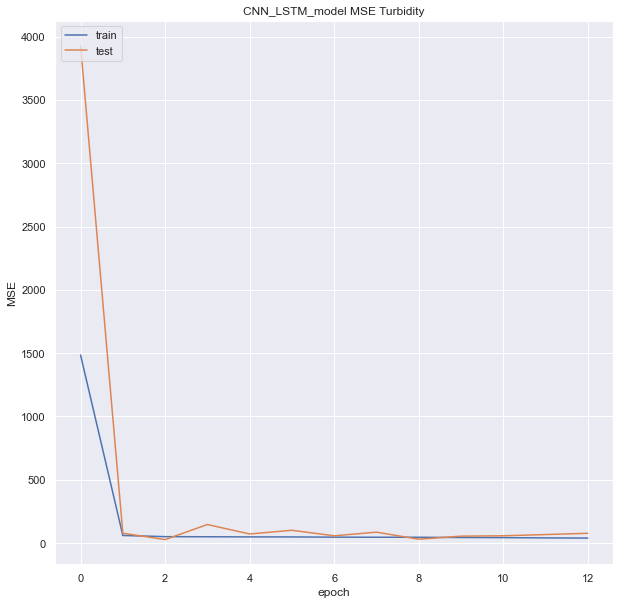

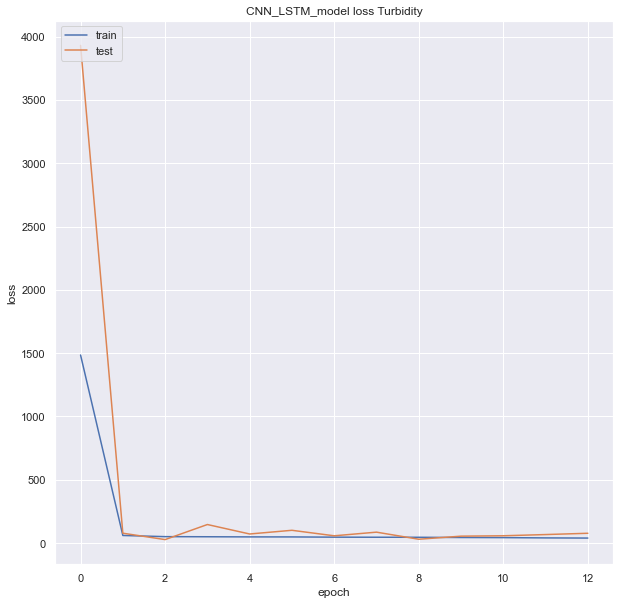

In [161]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Turbidity')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_turbidity.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Turbidity')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_turbidity.png")

483/483 - 1s - loss: 266.3497 - mse: 266.3497 - 842ms/epoch - 2ms/step

MSE: 266.3497314453125
483/483 [==============================] - 2s 2ms/step


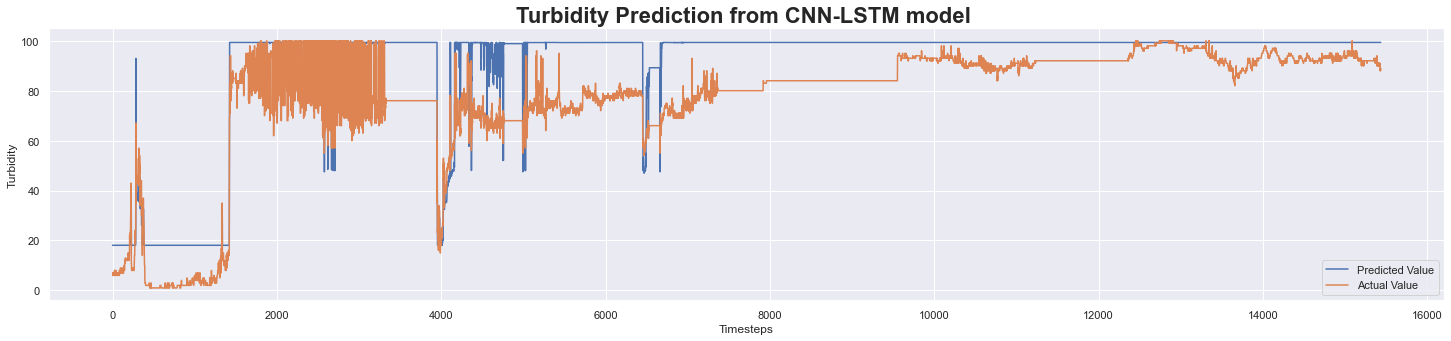

In [162]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/turbidity_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Turbidity Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Turbidity')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/turbidity_predictions.png")

## Dissolved Oxygen Predictions

This section uses the same architecture as the previous models with Conv1D layers, BatchNormalization and Dropout layers, an LSTM layer, a Dense layer with linear activation, and an Adam optimizer with a learning rate of 0.01.

In [163]:
# Set the training arrays and labels
X_train = train_df[['Dissolved Oxygen']]
y_train = train_df['Dissolved Oxygen']
X_test = val_df[['Dissolved Oxygen']]

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on your training data
# scaler.fit(X_train)

# X_train_norm = scaler.transform(X_train)
# X_test_norm = scaler.transform(X_test)

# Did Not Chose to Normalize/Standardize the data due to only using one feature
X_train_norm = X_train
X_test_norm = X_test


In [164]:
# Start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1

# Get the number of rows in the training data
num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
    seq_labs.append([train_df['Dissolved Oxygen'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [165]:
# Set the validation arrays and labels
val_arrays = []
val_labs = []
# Get the number of rows in the validation data
num_test_rows=val_df.shape[0]
# Set the starting index for the validation data
i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Dissolved Oxygen'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Dissolved Oxygen'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Dissolved Oxygen"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [166]:
# Print the shape of the training and validation arrays
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [167]:
# Build the model
from keras.layers import Conv1D, BatchNormalization
model_path = './Models/CNN_LSTM_model_dissolvedOx.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 2, 32)             96        
                                                                 
 batch_normalization_32 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_43 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_33 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_33 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_44 (Dropout)        (None, 2, 48)           

In [168]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 13s - loss: 37.3482 - mse: 37.3482 - val_loss: 67.7320 - val_mse: 67.7320 - 13s/epoch - 11ms/step
Epoch 2/100
1174/1174 - 8s - loss: 35.4700 - mse: 35.4700 - val_loss: 39.6784 - val_mse: 39.6784 - 8s/epoch - 6ms/step
Epoch 3/100
1174/1174 - 6s - loss: 35.0367 - mse: 35.0367 - val_loss: 71.1779 - val_mse: 71.1779 - 6s/epoch - 5ms/step
Epoch 4/100
1174/1174 - 6s - loss: 34.5865 - mse: 34.5865 - val_loss: 92.6024 - val_mse: 92.6024 - 6s/epoch - 5ms/step
Epoch 5/100
1174/1174 - 6s - loss: 34.5717 - mse: 34.5717 - val_loss: 131.2973 - val_mse: 131.2973 - 6s/epoch - 5ms/step
Epoch 6/100
1174/1174 - 6s - loss: 34.7388 - mse: 34.7388 - val_loss: 52.7739 - val_mse: 52.7739 - 6s/epoch - 5ms/step
Epoch 7/100
1174/1174 - 7s - loss: 34.3919 - mse: 34.3919 - val_loss: 87.8016 - val_mse: 87.8016 - 7s/epoch - 6ms/step
Epoch 8/100
1174/1174 - 6s - loss: 34.4334 - mse: 34.4334 - val_loss: 50.5270 - val_mse: 50.5270 - 6s/epoch - 5ms/step
Epoch 9/100
1174/1174 - 6s - loss: 34.1740 

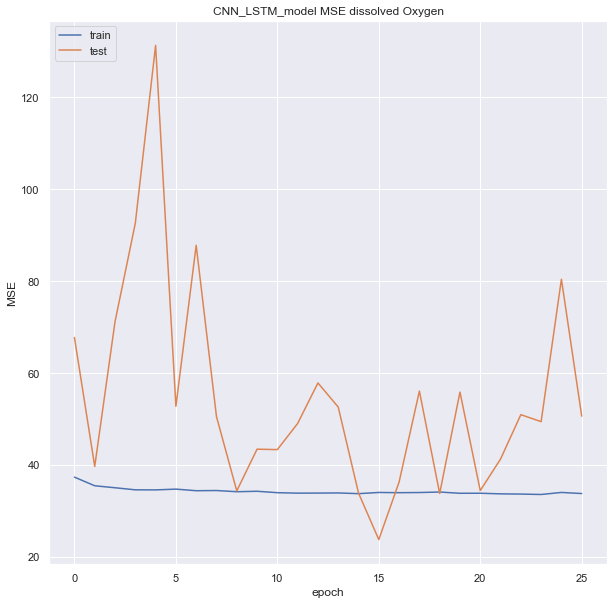

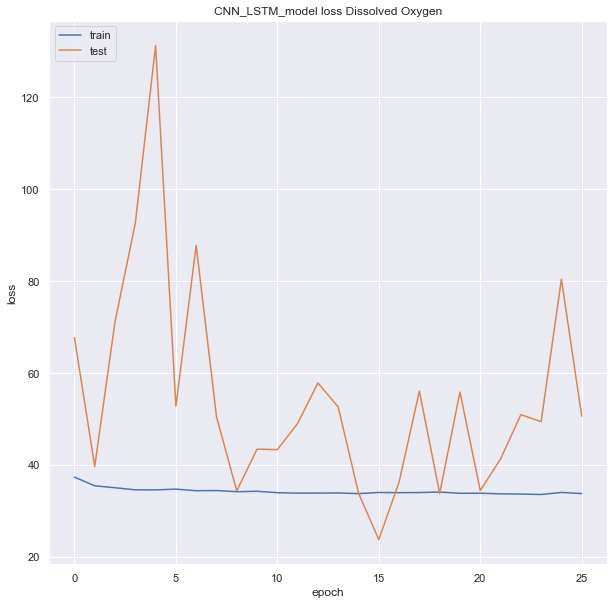

In [169]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE dissolved Oxygen')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_dissolvedOx.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Dissolved Oxygen')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_dissolvedOx.png")

483/483 - 1s - loss: 21.3596 - mse: 21.3596 - 810ms/epoch - 2ms/step

MSE: 21.359642028808594
483/483 [==============================] - 2s 3ms/step


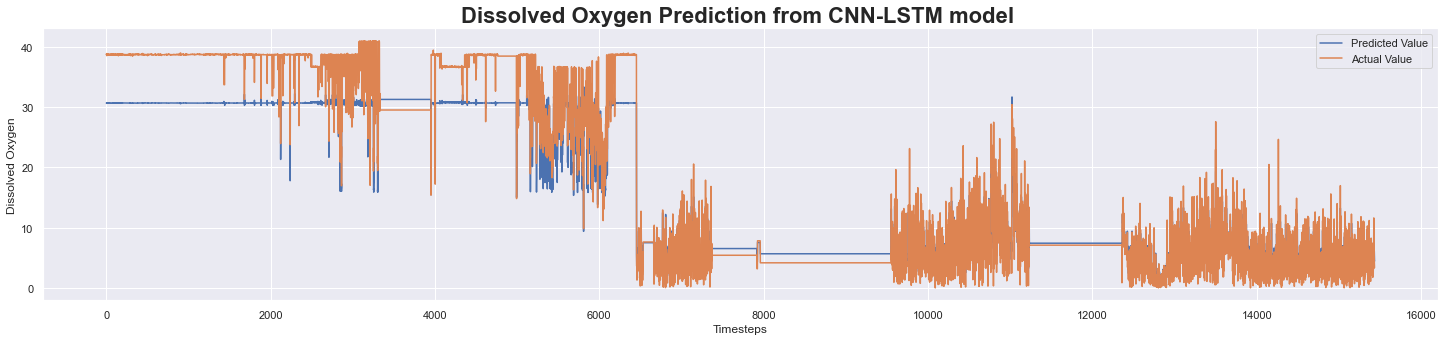

In [170]:
# Evaluate the model on the test data using `evaluate`
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/dissolvedOx_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Dissolved Oxygen Prediction from CNN-LSTM model ', fontsize=22, fontweight='bold')
plt.ylabel('Dissolved Oxygen')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/dissolvedOx_predictions.png")

## Ammonia

This section uses the same architecture as the previous models, with Conv1D layers, BatchNormalization and Dropout layers, an LSTM layer, a Dense layer with linear activation, and an Adam optimizer with a learning rate of 0.001.

In [205]:
#  Set the training arrays and labels
X_train = train_df[['Ammonia']]
y_train = train_df['Ammonia']
X_test = val_df[['Ammonia']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# # Did not use the scaler as it did not improve the model
# X_train_norm = X_train
# X_test_norm = X_test

In [206]:
# Start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1

# Get the number of rows in the training data
num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Ammonia'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [207]:
# Set the validation arrays and labels
val_arrays = []
val_labs = []
# Get the number of rows in the validation data
num_test_rows=val_df.shape[0]
# Set the starting index for the validation data
i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Ammonia'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Ammonia'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Ammonia"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [208]:
# print the shape of the training and validation arrays
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 1) (15435, 1) (61744, 2, 1) (61744, 1)


In [209]:
# Build the model
from keras.layers import Conv1D, BatchNormalization, Dropout, MaxPooling1D, Flatten
model_path = './Models/CNN_LSTM_model_ammonia.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Pooling layer
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.1)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 2, 32)             96        
                                                                 
 batch_normalization_54 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 dropout_68 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_55 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 batch_normalization_55 (Bat  (None, 2, 48)            192       
 chNormalization)                                                
                                                                 
 dropout_69 (Dropout)        (None, 2, 48)           

In [210]:
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 25s - loss: 105061801694647549952.0000 - mse: 105061792898554527744.0000 - val_loss: 1054507.1250 - val_mse: 1054507.1250 - 25s/epoch - 21ms/step
Epoch 2/100
1174/1174 - 9s - loss: 105061757714182438912.0000 - mse: 105061757714182438912.0000 - val_loss: 3936370.5000 - val_mse: 3936370.5000 - 9s/epoch - 8ms/step
Epoch 3/100
1174/1174 - 9s - loss: 105061748918089416704.0000 - mse: 105061748918089416704.0000 - val_loss: 8200639.5000 - val_mse: 8200639.5000 - 9s/epoch - 8ms/step
Epoch 4/100
1174/1174 - 9s - loss: 105061722529810350080.0000 - mse: 105061722529810350080.0000 - val_loss: 14235506.0000 - val_mse: 14235506.0000 - 9s/epoch - 8ms/step
Epoch 5/100
1174/1174 - 10s - loss: 105061581792321994752.0000 - mse: 105061581792321994752.0000 - val_loss: 21465484.0000 - val_mse: 21465486.0000 - 10s/epoch - 8ms/step
Epoch 6/100
1174/1174 - 9s - loss: 105061801694647549952.0000 - mse: 105061792898554527744.0000 - val_loss: 31171542.0000 - val_mse: 31171542.0000 - 9s/epoc

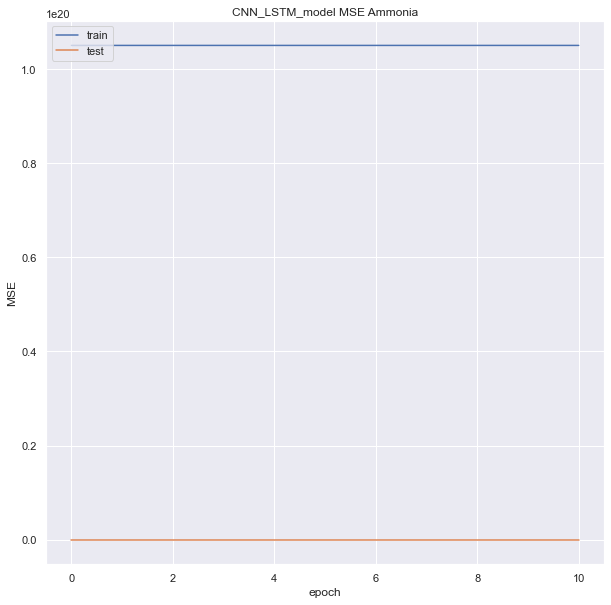

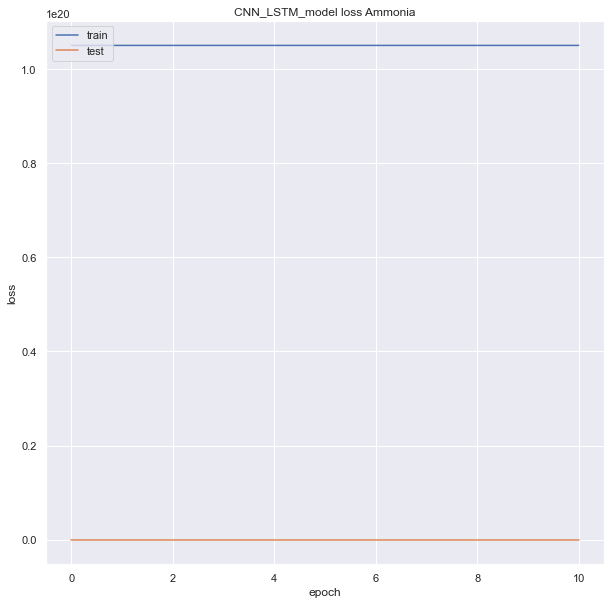

In [211]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Ammonia')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_Ammonia.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Ammonia')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_ammonia.png")


483/483 - 2s - loss: 175427312.0000 - mse: 175427312.0000 - 2s/epoch - 4ms/step

MSE: 175427312.0
483/483 [==============================] - 4s 4ms/step


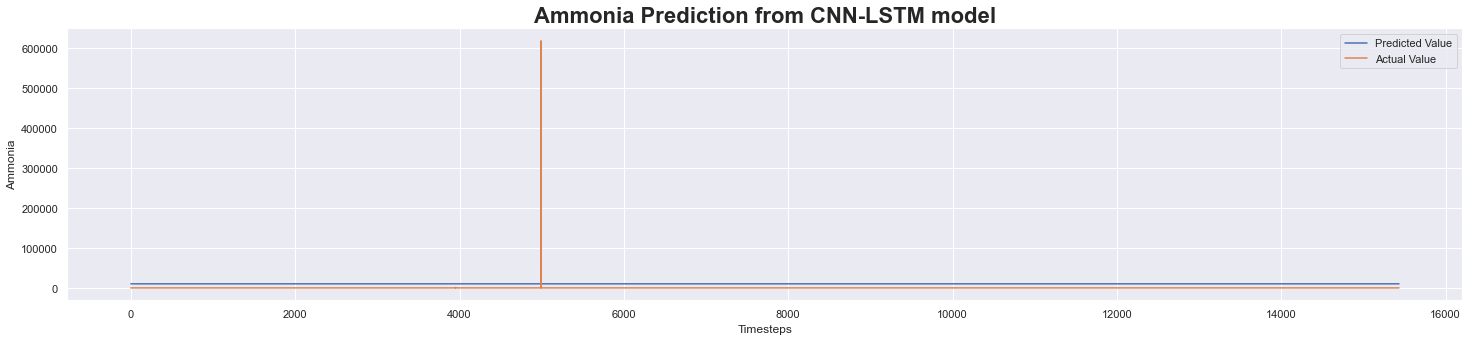

In [212]:
# Evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/ammonia_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Ammonia Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('Ammonia')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/Ammonia_Predictions.png")

## Nitrate

This section builds a model to predict nitrate values. It has a similar architecture as the previous models with Conv1D layers, BatchNormalization and Dropout layers, an LSTM layer, and a Dense layer with linear activation. However, the third Conv1D layer is commented out. The Adam optimizer is used with a higher learning rate of 1, and the model is compiled with mean squared error loss

In [195]:
# X_train = train_df.drop("Temperature",axis=1)
X_train = train_df[['Nitrate','Turbidity','PH']]
y_train = train_df['Nitrate']
# X_test = val_df.drop("Temperature",axis=1)
X_test = val_df[['Nitrate','Turbidity','PH']]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on your training data
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [196]:
# Start out with a 2 minute input sequence and a one minute predictive horizon
seq_arrays = []
seq_labs = []
seq_length = 2
ph = 1

# Get the number of rows in the training data
num_train_rows=train_df.shape[0]

#create list of sequence length Temperature readings
for start in range(0,num_train_rows-seq_length-ph):
    seq_arrays.append(X_train_norm[start:start+seq_length])
#     seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
    seq_labs.append([train_df['Nitrate'].iloc[start:start+seq_length+1].to_numpy()[-1]])

seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [197]:
# Set the validation arrays and labels
val_arrays = []
val_labs = []
# Get the number of rows in the validation data
num_test_rows=val_df.shape[0]
# Set the starting index for the validation data
i=1

#create list of Temperature readings starting with a minimum of two readings
for start in range(2,num_test_rows):
    incoming_df=val_df[0:start] 
    
    if len(incoming_df) > seq_length: 
        
        val_arrays.append(X_test_norm[i:i+seq_length])
        val_labs.append([incoming_df['Nitrate'].iloc[i:i+seq_length+ph].to_numpy()[-1]])
        i+=1
        
    else:
        
        val_arrays.append(X_test_norm[0:len(incoming_df)])
        val_labs.append([incoming_df['Nitrate'].iloc[0:len(incoming_df)+ph].to_numpy()[-1]])
        
# use the pad_sequences function on your input sequences
val_arrays = tf.keras.preprocessing.sequence.pad_sequences(val_arrays, dtype='float32', padding='post',value=val_df["Nitrate"].mean())     

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [198]:
# print the shape of the arrays
print(val_arrays.shape,val_labs.shape,seq_arrays.shape,seq_labs.shape)

(15435, 2, 3) (15435, 1) (61744, 2, 3) (61744, 1)


In [199]:
# Build the model
from keras.layers import Conv1D, BatchNormalization,MaxPooling1D,Flatten
from keras import regularizers

model_path = 'CNN_LSTM_model_Nitrate.h5'
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]
model = Sequential()

model.add(Conv1D(32,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
# model.add(Dropout(0.6))

model.add(Conv1D(48,kernel_size=2,padding="causal",activation="relu",dilation_rate=2,kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=4,kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=1))
model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(LSTM(10))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.2))

model.add(Dense(units = nb_out))
model.add(Activation("linear"))
optimizer = keras.optimizers.Adam(learning_rate = 0.1)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_51 (Conv1D)          (None, 2, 32)             224       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 batch_normalization_51 (Bat  (None, 2, 32)            128       
 chNormalization)                                                
                                                                 
 conv1d_52 (Conv1D)          (None, 2, 48)             3120      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2, 48)            0         
 1D)                                                             
                                                     

In [200]:
# Fit the model
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=50,validation_split=0.05, verbose=2,
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=10, verbose=0, mode='min'),
keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)])
# list all data in history
print(history.history.keys())

Epoch 1/100
1174/1174 - 25s - loss: 985.0715 - mse: 931.5123 - val_loss: 41300.6680 - val_mse: 41240.1406 - 25s/epoch - 21ms/step
Epoch 2/100
1174/1174 - 10s - loss: 920.8123 - mse: 802.0668 - val_loss: 7815.6323 - val_mse: 7671.7388 - 10s/epoch - 8ms/step
Epoch 3/100
1174/1174 - 10s - loss: 794.9540 - mse: 629.6251 - val_loss: 7052.6787 - val_mse: 6863.6411 - 10s/epoch - 9ms/step
Epoch 4/100
1174/1174 - 10s - loss: 802.3000 - mse: 624.9757 - val_loss: 11727.7939 - val_mse: 11515.2744 - 10s/epoch - 9ms/step
Epoch 5/100
1174/1174 - 10s - loss: 643.8606 - mse: 487.5579 - val_loss: 7574.9985 - val_mse: 7433.4507 - 10s/epoch - 8ms/step
Epoch 6/100
1174/1174 - 10s - loss: 642.8723 - mse: 531.0856 - val_loss: 85953.6719 - val_mse: 85869.4141 - 10s/epoch - 9ms/step
Epoch 7/100
1174/1174 - 10s - loss: 705.3214 - mse: 597.6967 - val_loss: 37139.9102 - val_mse: 37049.4805 - 10s/epoch - 9ms/step
Epoch 8/100
1174/1174 - 10s - loss: 1168.0469 - mse: 1019.2633 - val_loss: 12284.7295 - val_mse: 12016

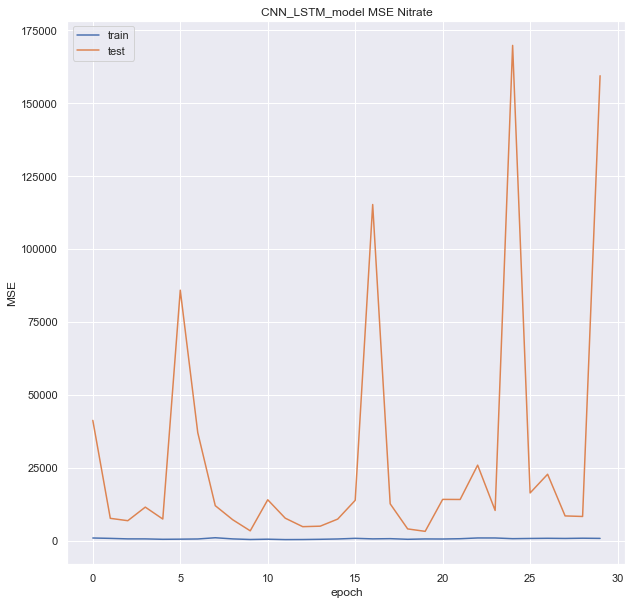

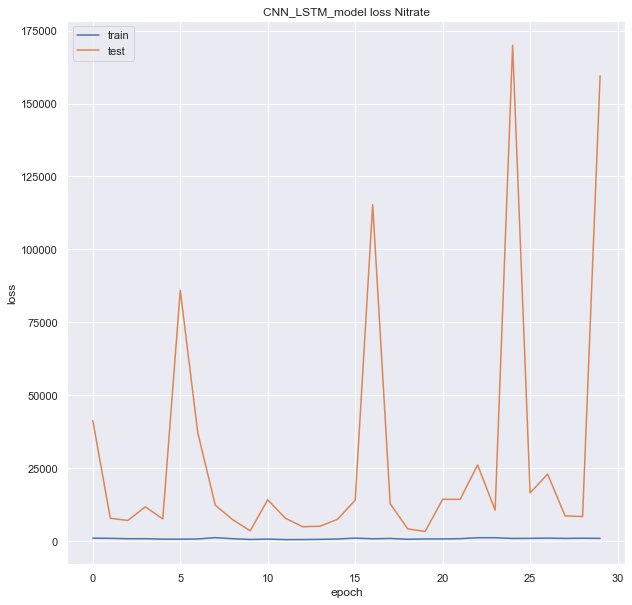

In [201]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('CNN_LSTM_model MSE Nitrate')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_mse_Nitrate.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN_LSTM_model loss Nitrate')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Images/CNN_LSTM_loss_nitrate.png")


483/483 - 2s - loss: 357304.9375 - mse: 357204.9688 - 2s/epoch - 5ms/step

MSE: 357204.96875
483/483 [==============================] - 5s 6ms/step


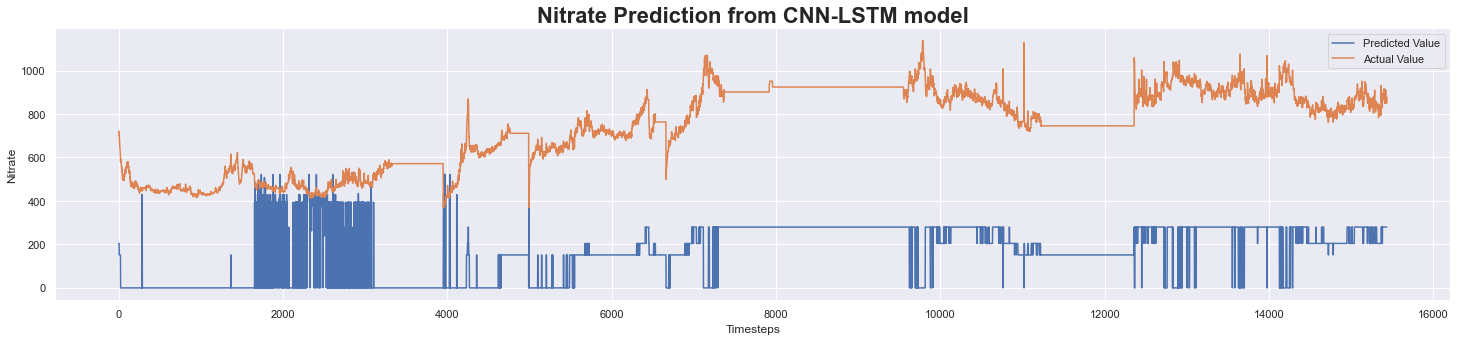

In [202]:
# Evaluate the model
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('./Predictions/nitrate_predictions.csv', index = None)

# Plot the predicted data vs. the actual data
fig_verify = plt.figure(figsize=(25, 5))
plt.plot(y_pred_test, label = 'Predicted Value')
plt.plot(y_true_test, label = 'Actual Value')
plt.title('Nitrate Prediction from CNN-LSTM model', fontsize=22, fontweight='bold')
plt.ylabel('Nitrate')
plt.xlabel('Timesteps')
plt.legend()
plt.show()
fig_verify.savefig("./Images/Nitrate_Predictions.png")

# Functions for Predictions and Saving to CSV

In [213]:
# Create new DataFrame with "cleaned_pond2" and append the predicted values to it for each timestep for each attribute

# Read in dataframe and skip the first 2 rows
combined_df = pd.read_csv('../Data/val_df.csv', delimiter=',', low_memory=False, skiprows=3, header=None)

combined_df.columns = ['Datetime', 'Temperature', 'Turbidity', 'Dissolved Oxygen', 'PH',
       'Ammonia', 'Nitrate']

#  Create new column and shift down two rows 
combined_df["Temperature_Predict"] = pd.read_csv('./Predictions/temperature_predictions.csv')
combined_df["PH_Predict"] = pd.read_csv('./Predictions/ph_predictions.csv')
combined_df["Turbidity_Predict"] = pd.read_csv('./Predictions/turbidity_predictions.csv')
combined_df["Dissolved Oxygen Predict"] = pd.read_csv('./Predictions/dissolvedOx_predictions.csv')
combined_df["Ammonia_Predict"] = pd.read_csv('./Predictions/ammonia_predictions.csv')
combined_df['Nitrate_Predict'] = pd.read_csv('./Predictions/nitrate_predictions.csv')

# # Export the combined DataFrame to a CSV file
combined_df.to_csv('./Predictions/combined_pond.csv', index = None)
combined_df.to_csv('../Data/combined_pond.csv', index = None)


In [214]:
# Load the Validation DataFrame
combined_df1 = pd.read_csv('../Data/val_df.csv', delimiter=',', low_memory=False)
#  Get the first two rows (The data that can not be predicted)
first_two = combined_df1.head(2)

# print(first_two)
# print(combined_df.shape)

# Concatenate the two DataFrames
result = pd.concat([first_two, combined_df])

# print(result.shape)

# Convert the Datetime column to datetime
result['Datetime'] = pd.to_datetime(result.Datetime,infer_datetime_format=True)
# sort by date
result.sort_values(by=['Datetime'], inplace=True, ascending=True)
# print(result.head())
result.to_csv('../Data/combined_pond_result.csv', index = None)
